In [ ]:
# define a function to check for successful installation of the libraries
def lib_installation_check(captured_data, n_lines_print):
    """
    A function to use the %%capture output from the cells where we try to install the libraries.
    It would print last "n_lines_print" if there is an error in library installation
    """
    output_text = captured_data.stdout
    lines = output_text.splitlines()
    output_last_n_lines = '\n'.join(lines[-n_lines_print:])
    if "error" in output_last_n_lines.lower():
        print("Library installation failed!")
        print("--- Error Details ---")
        print(output_last_n_lines)
    else:
        print("Library installation was successful, let's proceed ahead")

In [ ]:
%%time
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork


CPU times: user 4.5 s, sys: 658 ms, total: 5.16 s
Wall time: 16.3 s


In [ ]:
lib_installation_check(captured_data = captured_output, n_lines_print = 5)

Library installation was successful, let's proceed ahead


In [ ]:
%%time
%pip install tensorflow==2.19

CPU times: user 1.93 s, sys: 284 ms, total: 2.22 s
Wall time: 5.36 s


In [ ]:
%pip install scikit-learn==1.7.0

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import sys
import time
import shutil
import random
import numpy as np
import skillsnetwork
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
extract_dir = "."

In [ ]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"

In [ ]:
## Download and extract data from the cloud

def check_skillnetwork_extraction(extract_dir):
    """ function to check whether data download and extraction method
    `skillsnetwork.prepare` would execute successfully, without downloading any data.
    This helps in early detection and fast fallback to explicit download and extraction
    using default libraries
    ###This is a hack for the code to run on non-cloud computing environment without errors
    """
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test)
        print("Write permissions available for downloading and extracting the dataset tar file")
    os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """function to explicitly download and extract the dataset tar file from cloud using native python libraries
    """
    if not os.path.exists(tar_path): # download only if file not downloaded already
        try:
            print(f"Downloading from {url}...")
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)# Download the file asynchronously
                response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)

                with open(tar_path , "wb") as f:
                    f.write(response.content) # Save the downloaded file
                print(f"Successfully downloaded '{file_name}'.")
        except httpx.HTTPStatusError as http_err:
            print(f"HTTP error occurred during download: {http_err}")
        except Exception as download_err:
            print(f"An error occurred during the fallback process: {download_err}")
    else:
        print(f"dataset tar file already downloaded at: {tar_path}")
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
    print(f"Successfully extracted to '{extract_dir}'.")



In [ ]:
try:
    check_skillnetwork_extraction(extract_dir)
    await skillsnetwork.prepare(url = url, path = extract_dir, overwrite = True)
except Exception as e:
    print(e)
    # --- FALLBACK METHOD FOR DOWNLOADING THE DATA ---
    print("Primary download/extration method failed.")
    print("Falling back to manual download and extraction...")

    # import libraries required for downloading and extraction
    import tarfile
    import httpx
    from pathlib import Path

    file_name = Path(url).name# Get the filename from the URL (for example, 'data.tar')
    tar_path = os.path.join(extract_dir, file_name)
    print(f"tar_path: {os.path.exists(tar_path)} ___ {tar_path}")
    await download_tar_dataset(url, tar_path, extract_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


In [ ]:
## Import deep learning and ML libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score
print("Succesfully imported the libraries")



Succesfully imported the libraries


In [ ]:
## Get the processing device
gpu_list = tf.config.list_physical_devices('GPU')

device = "gpu" if gpu_list !=[] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu


In [ ]:
## Reproducibility with random seeds

# Set seed for reproducibility
seed_value = 7331
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
dataset_path = os.path.join(extract_dir, "images_dataSAT")
print(dataset_path)

./images_dataSAT


In [ ]:
## Create the dataset file list
## Recursively walk through the dataset_path

fnames= []

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        fnames.append(os.path.join(dirname, filename))
print(f"total files in dataset: {len(fnames)}")
nfname_print=2
for f in fnames[:nfname_print]:
    print(f)
for f in fnames[-nfname_print:]:
    print(f)

total files in dataset: 6000
./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_6997.jpg
./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_14191.jpg
./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_9405.jpg
./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_2380.jpg


In [ ]:
## Define the model hyperparameters

img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
lr = 0.001 # Learning rate
n_epochs = 3 # set to low number for your convenience. You can change this to any number of your liking

steps_per_epoch = None
validation_steps = None

model_name = "ai_capstone_keras_best_model.model.keras"

In [ ]:
## Configure `ImageDataGenerator` for Augmentation


datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest",
                             validation_split=0.2
                            )

In [ ]:
## Create training and validation data generators
train_generator = datagen.flow_from_directory(dataset_path,
 target_size = (img_w, img_h),
 batch_size= batch_size,
 class_mode="binary",
 subset="training"
 )
validation_generator = datagen.flow_from_directory(dataset_path,
 target_size = (img_w, img_h),
 batch_size= batch_size,
 class_mode="binary",
 subset="validation"
 )

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [ ]:
## Model definition and compilation

model = Sequential([
                    Conv2D(32 , (5,5) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
                    MaxPooling2D(2,2),
                    BatchNormalization(),

                    Conv2D(64, (5,5) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),

                    Conv2D(128, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),

                    ###
                    Conv2D(256, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),

                    Conv2D(512, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),

                    Conv2D(1024, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),


                    ###
                    GlobalAveragePooling2D(),

                    Dense(64,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),

                    Dense(128,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),

                    Dense(256,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),

                    ###
                    Dense(512,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),

                    Dense(1024,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),

                    Dense(2048,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),


                    ###
                    Dense(1 , activation="sigmoid")

                ])

In [ ]:
## Compile the model and display the summary

loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),
              loss=loss,
              metrics=["accuracy"])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,352,897 (77.64 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

None


In [ ]:
## Create and compile a CNN model test_model with 4 Conv2D layers and 5 Dense layers.
model = Sequential([
 Conv2D(32 , (5,5) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
 MaxPooling2D(2,2),
 BatchNormalization(),

 Conv2D(64, (5,5) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),

 Conv2D(128, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),

###
 Conv2D(256, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
 MaxPooling2D(2,2),
 BatchNormalization(),

###
 GlobalAveragePooling2D(),

 Dense(64,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

 Dense(128,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

 Dense(256,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

###
 Dense(512,activation="relu" , kernel_initializer=HeUniform()),
 BatchNormalization(),
 Dropout(0.4),

###
 Dense(1 , activation="sigmoid")

 ])

# Compile the model to make it ready for training
loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),loss=loss, metrics=["accuracy"])

In [ ]:
## Model training

print(f"Training Hyperparameters:\n\
        n_classes (train) = {train_generator.num_classes},\n\
        n_classes (validation) = {validation_generator.num_classes},\n\
        img_w, img_h ={img_w, img_h},\n\
        n_channels = {n_channels},\n\
        batch_size = {batch_size},\n\
        steps_per_epoch = {steps_per_epoch},\n\
        n_epochs = {n_epochs},\n\
        validation_steps = {validation_steps},\n\
        learning_rate = {lr}")

Training Hyperparameters:
        n_classes (train) = 2,
        n_classes (validation) = 2,
        img_w, img_h =(64, 64),
        n_channels = 3,
        batch_size = 128,
        steps_per_epoch = None,
        n_epochs = 3,
        validation_steps = None,
        learning_rate = 0.001


In [ ]:
## Save the model checkpoint with maximum accuracy

checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose=1
                               )

In [ ]:
## Execute model training
print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

fit = model.fit(train_generator,
                epochs= n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=(validation_generator),
                validation_steps = validation_steps,
                callbacks=[checkpoint_cb],
                verbose=1
               )

Training on : ===cpu=== with batch size: 128 & lr: 0.001
Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8286 - loss: 0.3548
Epoch 1: val_accuracy improved from -inf to 0.52833, saving model to ai_capstone_keras_best_model.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.8308 - loss: 0.3508 - val_accuracy: 0.5283 - val_loss: 1.7178
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9786 - loss: 0.0660
Epoch 2: val_accuracy did not improve from 0.52833
38/38 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.9786 - loss: 0.0662 - val_accuracy: 0.4608 - val_loss: 2.7935
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9810 - loss: 0.0559
Epoch 3: val_accuracy improved from 0.52833 to 0.82667, saving model to ai_capstone_keras_best_model.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.9809 - loss: 0.0561 - val_accuracy: 0.8267 - val_loss: 0.3987


In [ ]:
## Model evaluation and visualization

steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
batch_size = int(validation_generator.batch_size)

all_preds = []
all_labels = []
for step in range(steps):
    # Get one batch data
    images, labels = next(validation_generator)
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten()
    all_preds.extend(preds)
    all_labels.extend(labels)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy Score: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
Accuracy Score: 0.8308


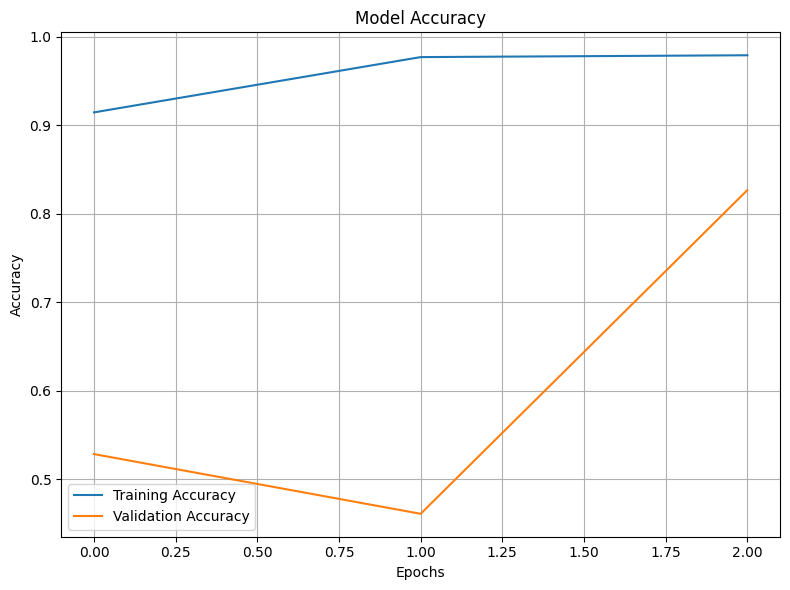

In [ ]:
## Visualize the training history

# Create a figure with a subplot
fig, axs = plt.subplots(figsize=(8, 6))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history['val_accuracy'], label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

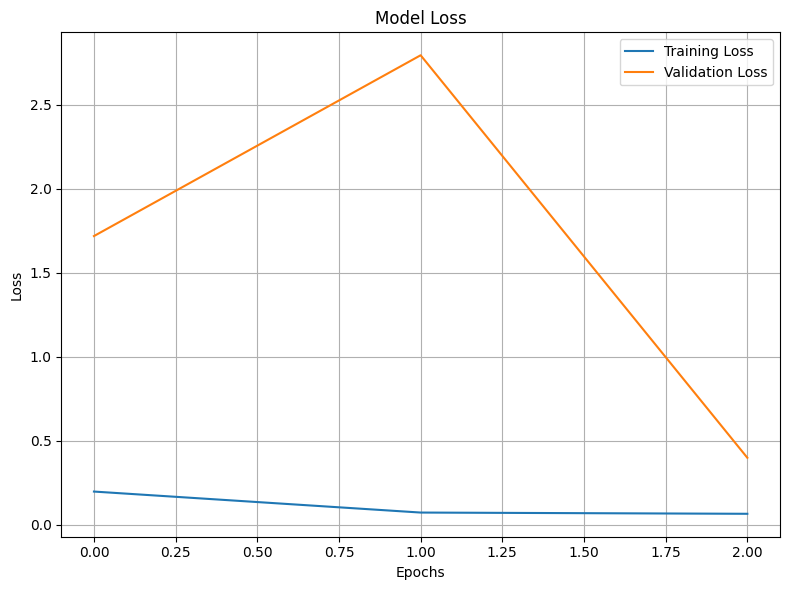

In [ ]:
fig, axs = plt.subplots( figsize=(8, 6))


# Plot Loss on the second subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()